In [17]:
name = 'Road_Traffic_Fine_Management_Process'
df_train = remove_incomplete(get_train_data(name))
df_test = get_test_data(name)
print('got data')

df_train = get_time_to_end(df_train)
df_train = get_total_time_passed(df_train)
df_test = get_time_to_end(df_test)
df_test = get_total_time_passed(df_test)
print('got extra columns')

got data
got extra columns


In [18]:
ordered_casedurations = df_train.groupby('case concept:name').head(1)[['time-to-end', 'event time:timestamp']].sort_values('event time:timestamp')
#estimated = []
#estimated.append(ordered_casedurations[ordered_casedurations['event time:timestamp'] < row['event time:timestamp']]['time-to-end'].apply(to_seconds).mean()-row['inter-event-time'].total_seconds())
def get_blocked_means(nblocks, df_train):
    ordered_means = {}
    ordered_casedurations = df_train.groupby('case concept:name').head(1)[['time-to-end', 'event time:timestamp']].sort_values('event time:timestamp')
    le = int(len(ordered_casedurations)/nblocks)
    k = 0
    for i in range(0, len(ordered_casedurations), le):
        if k == nblocks-1:
            ordered_means[ordered_casedurations.iloc[i+le]['event time:timestamp']] = ordered_casedurations.iloc[0:len(ordered_casedurations)]['time-to-end'].apply(to_seconds).mean()
            break
        else:
            ordered_means[ordered_casedurations.iloc[i+le]['event time:timestamp']] = ordered_casedurations.iloc[0:i+le]['time-to-end'].apply(to_seconds).mean()
        k += 1
    return ordered_means

ordered_means = get_blocked_means(100, df_train)

In [19]:
estimated = []
nblocks = 100
for index, row in df_test.iterrows():
    for i in range(nblocks):
        if list(ordered_means.keys())[i] > row['event time:timestamp']:
            break
    if i == 0:
        estimated.append(-1)
    else:
        estimated.append(ordered_means[list(ordered_means.keys())[i-1]])

In [20]:
df_test['estimator'] = estimated
df_test['estimator'] = df_test['estimator'] - df_test['inter-event-time'].apply(to_seconds)

In [21]:
df_test.loc[df_test['estimator']<0, 'estimator'] = 0

In [22]:
math.sqrt(sum((df_test['time-to-end'].apply(to_seconds) - df_test['estimator']).apply(lambda x: x ** 2)) / len(df_test)) / 3600 / 24

303.01012338658416

In [24]:
df_train, le = convert_train(df_train)
df_test = convert_test(df_test, le)
df_test.to_pickle(name + 'predicted.dat')
df_train.to_pickle(name + 'extra-columns.dat')

AttributeError: 'float' object has no attribute 'total_seconds'

In [29]:
#run .py before continueing
name = 'Road_Traffic_Fine_Management_Process'
test_df = pd.read_pickle(name + 'predicted.dat')
train_df = pd.read_pickle(name + 'extra-columns.dat')

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
test_df['event time:timestamp'] = test_df['event time:timestamp'].apply(lambda a : a.day)/365+test_df['event time:timestamp'].apply(lambda a : a.year)+test_df['event time:timestamp'].apply(lambda a : a.month)/12

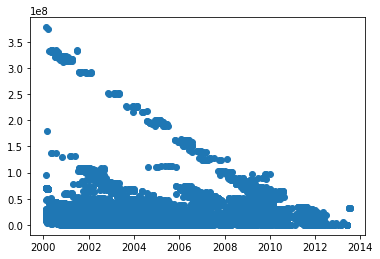

In [32]:
plt.scatter(test_df['event time:timestamp'] , abs(test_df['estimator']-test_df['time-to-end']))

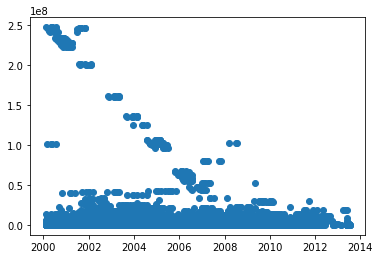

In [33]:
plt.scatter(test_df['event time:timestamp'] , abs(test_df['estimator2']-test_df['time-to-end']))

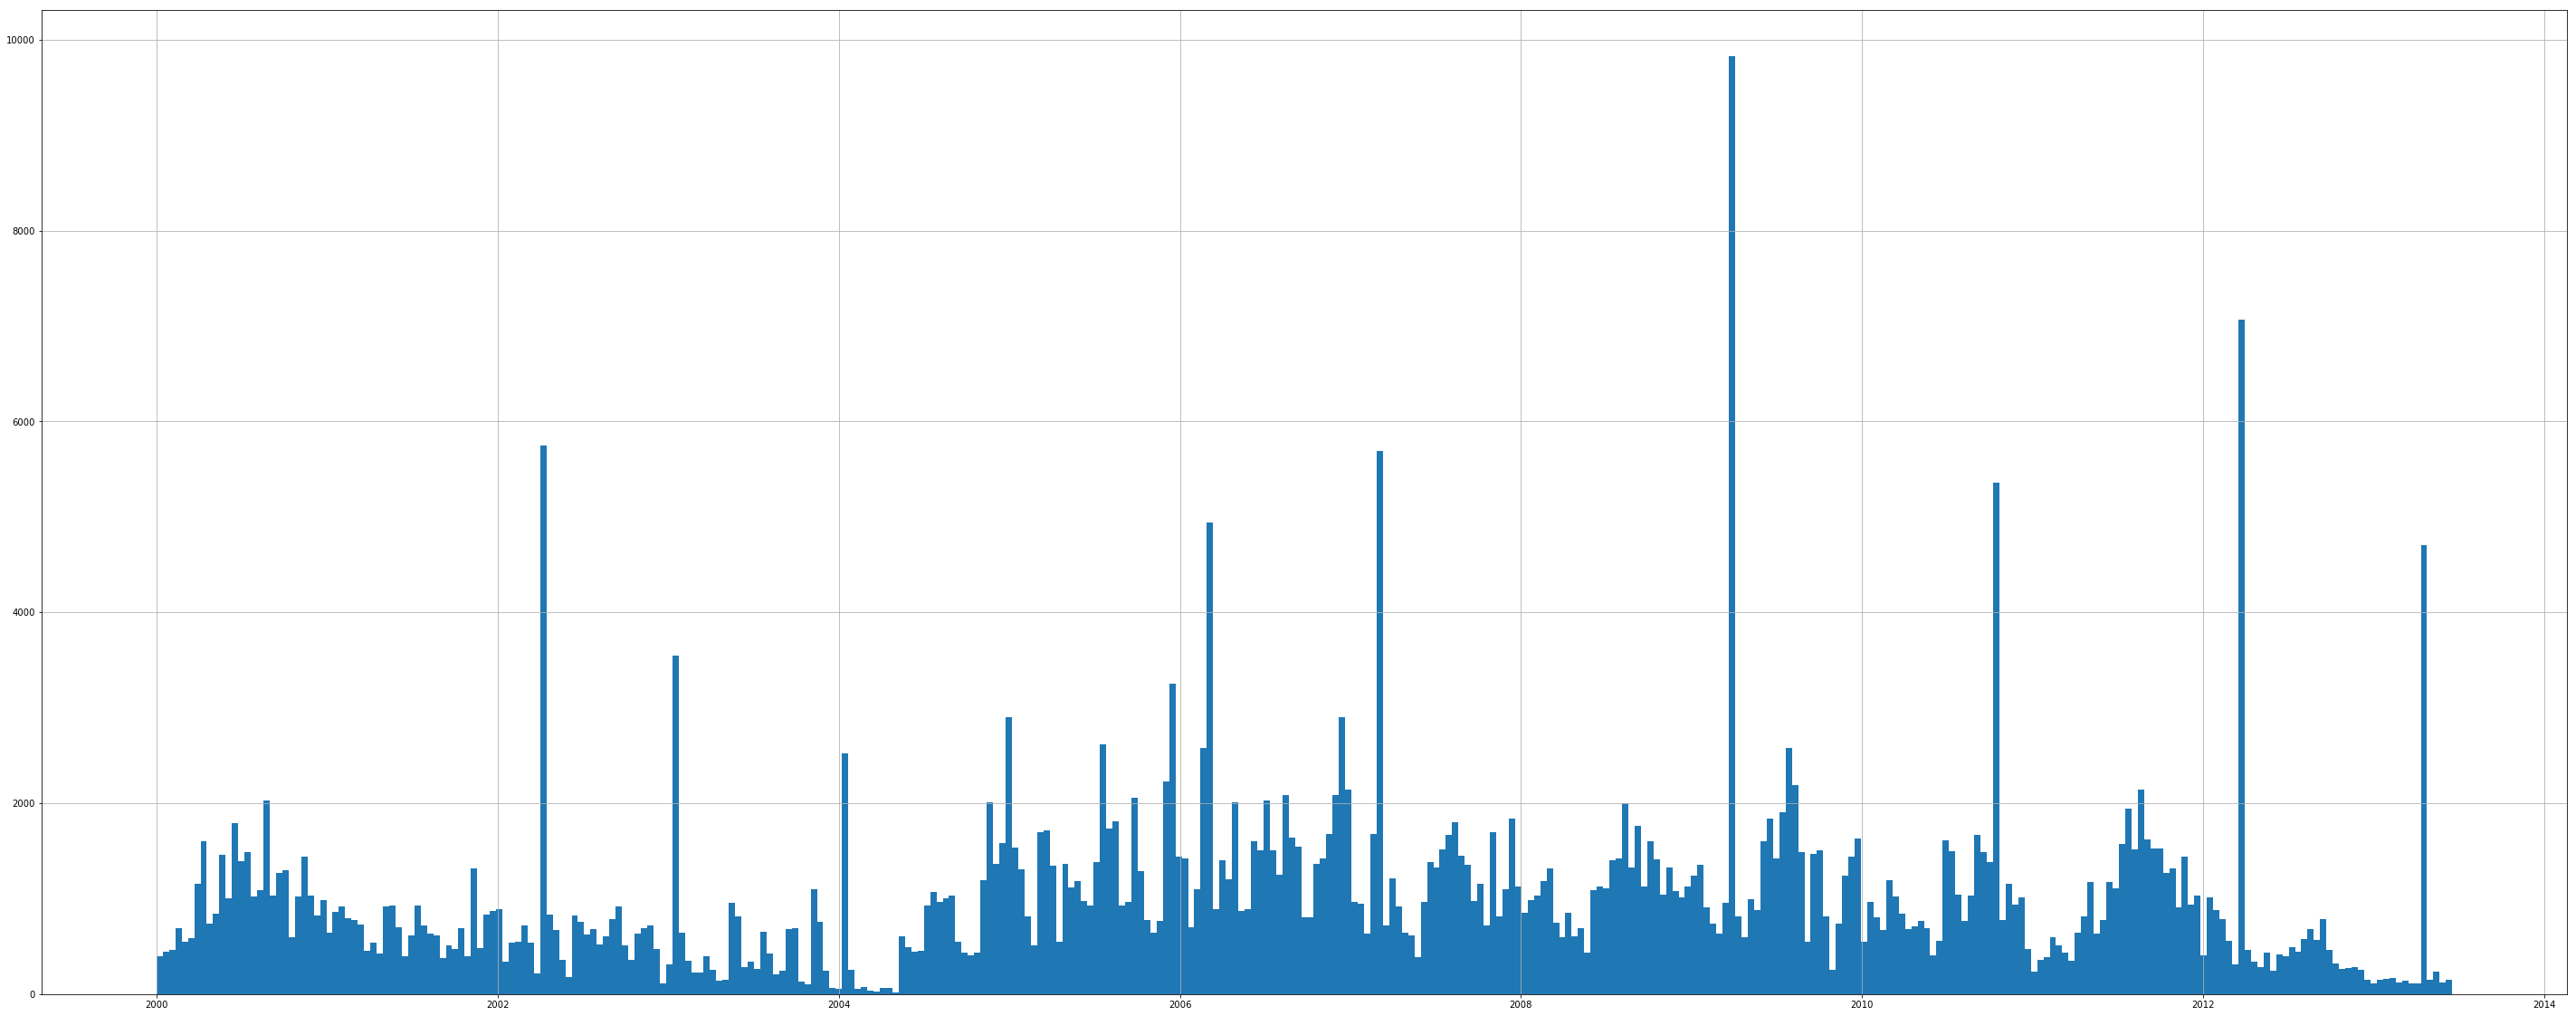

In [34]:
#train_df['event time:timestamp'] = train_df['event time:timestamp'].apply(lambda a : a.day)/365+train_df['event time:timestamp'].apply(lambda a : a.year)+train_df['event time:timestamp'].apply(lambda a : a.month)/12
train_df["event time:timestamp"].hist(bins=365, figsize=[50,20])

In [36]:
test_df.corr()

,eventID,event concept:name,event time:timestamp,time-to-end,inter-event-time,estimator,cluster,estimator2
eventID,1.000000,0.001213,0.517328,0.064500,0.067142,-0.130814,0.094283,0.061075
event concept:name,0.001213,1.000000,0.114991,-0.263316,0.450836,-0.434614,0.017194,-0.272106
event time:timestamp,0.517328,0.114991,1.000000,-0.026331,0.335551,-0.398396,0.104799,-0.026916
time-to-end,0.064500,-0.263316,-0.026331,1.000000,-0.305834,0.284413,0.219783,0.965835
inter-event-time,0.067142,0.450836,0.335551,-0.305834,1.000000,-0.898285,0.132542,-0.317477
estimator,-0.130814,-0.434614,-0.398396,0.284413,-0.898285,1.000000,-0.141656,0.295973
cluster,0.094283,0.017194,0.104799,0.219783,0.132542,-0.141656,1.000000,0.236628
estimator2,0.061075,-0.272106,-0.026916,0.965835,-0.317477,0.295973,0.236628,1.000000


In [2]:
import os
import pandas as pd
import datetime
import numpy as np
import math
from sklearn import tree, preprocessing
from sklearn.cluster import KMeans


# Method for transforming events into horizontal format.
def transform_event_data(df):
    case = None
    data = {}
    for index, row in df.iterrows():
        if case != row['case concept:name']:
            case = row['case concept:name']
        if case not in data.keys():
            data[case] = []
        data[case].append(float(row['event concept:name']) + 1)
        data[case].append(float(row['inter-event-time']))
    df = pd.DataFrame.from_dict(data, orient='index')
    return df, len(df.columns)


def to_seconds(x):
    return x.total_seconds()

In [5]:
name = 'BPI_Challenge_2019'
test_df = pd.read_pickle(name + 'predicted.dat')
train_df = pd.read_pickle(name + 'extra-columns.dat')

train_df = train_df.sort_values('event time:timestamp')
nblocks = 10
block_time = to_seconds(train_df['event time:timestamp'].max()-train_df['event time:timestamp'].min())/nblocks
btimes = [block_time + block_time*i for i in range(nblocks)]

train_df['time-since-start'] = (train_df['event time:timestamp']-train_df['event time:timestamp'].min()).apply(to_seconds)
samples = [train_df[train_df['time-since-start'] < btimes[i]].sort_values(['case concept:name', 'event time:timestamp']) for i in range(nblocks)]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: 'case concept:name' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  # This is added back by InteractiveShellApp.init_path()


In [6]:
train_means_blocked = []
amounts_models = []
train_dfs = []
for sample in samples:
    event_data_train, max_event = transform_event_data(sample)
    # Calculating means per event type per cluster for train set:
    clustering = KMeans(random_state=0, n_clusters=20)
    event_data_train['cluster'] = clustering.fit_predict(event_data_train.fillna(0))
    sample.index = sample['case concept:name']
    sample['cluster'] = event_data_train['cluster']
    train_means = pd.DataFrame(sample.groupby('case concept:name')['time-to-end'].max())
    train_means['cluster'] = event_data_train['cluster']
    train_means_blocked.append(train_means)
    amounts_models.append([clustering, max_event])
    train_dfs.append(sample)
train_df_b = pd.concat(train_dfs)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: 'case concept:name' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  # This is added back by InteractiveShellApp.init_path()


In [7]:
test_df['time-since-start'] = (test_df['event time:timestamp']-train_df['event time:timestamp'].min()).apply(to_seconds)
test_samples = [test_df[(test_df['time-since-start'] < btimes[i+1])&(test_df['time-since-start'] >= btimes[i])].sort_values(['case concept:name', 'event time:timestamp']) for i in range(nblocks-1)]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 'case concept:name' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  


In [8]:
test_dfs = []
for sample, amount_model, train_means in zip(test_samples, amounts_models[1:], train_means_blocked[1:]):
    clustering, max_event = amount_model
    event_data_test, amount = transform_event_data(sample)
    print(max_event, amount)
    if amount > max_event:
        for i in range(amount-max_event):
            del event_data_test[amount-i-1]
    else:
        for i in range(amount, amount + (max_event - amount), 1):
            event_data_test[i] = np.nan
    # Predict cluster on test set and use means per event type and per cluster as estimator:
    event_data_test['cluster'] = clustering.predict(event_data_test.fillna(0))
    sample.index = sample['case concept:name']
    sample['cluster'] = event_data_test['cluster']
    for cluster in list(train_means.groupby('cluster').mean().index):
        sample.loc[sample['cluster'] == cluster, 'estimator2'] = float(train_means.groupby('cluster').mean().loc[cluster])
    sample['estimator2'] = sample['estimator2'] - sample['inter-event-time']
    sample.loc[sample['estimator2'] < 0, 'estimator2'] = 0
    test_dfs.append(sample)
test_df_b = pd.concat(test_dfs)

18 20
30 20
30 18
30 18
34 18
34 18
34 18
40 20
40 12


In [9]:
# Calculate the error:
print(math.sqrt(sum((test_df_b['time-to-end'] - test_df_b['estimator2']).apply(lambda x: x ** 2)) / len(test_df_b)) / 3600 / 24)
# Save data again:
#test_df_b.to_pickle(name + 'predicted.dat')
#train_df_b.to_pickle(name + 'extra-columns.dat')

268.826621784506


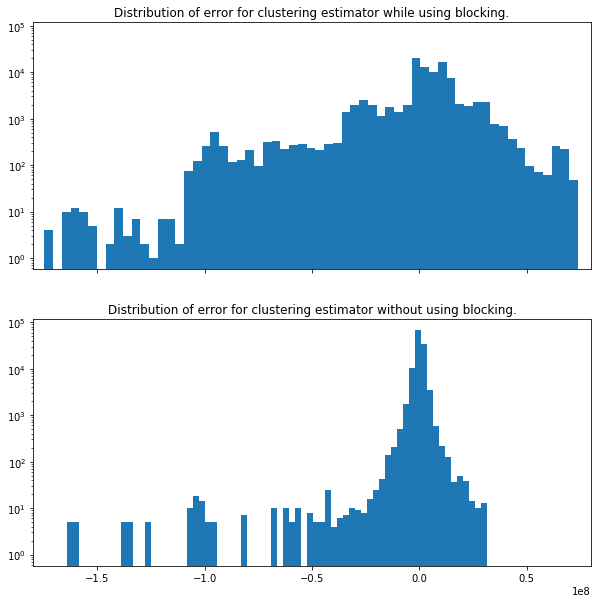

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=[10,10])

test_df_b['error'] = test_df_b['estimator2']-test_df_b['time-to-end']
ax[0].hist(test_df_b['error'], bins=100)
ax[0].set_title('Distribution of error for clustering estimator while using blocking.')

test_df['error'] = test_df['estimator2']-test_df['time-to-end']
ax[1].hist(test_df['error'], bins=100)
ax[1].set_title('Distribution of error for clustering estimator without using blocking.')
ax[0].set_xlim([-180000000,80000000])
ax[0].set_yscale('log')
ax[1].set_yscale('log')

In [11]:
test_df_b.to_pickle(name + '2predicted.dat')
train_df_b.to_pickle(name + '2extra-columns.dat')

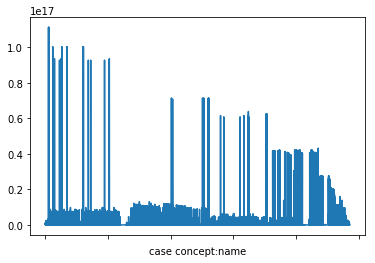

In [27]:
test_df_b.sort_values('event time:timestamp')['error'].apply(lambda a : a**2).plot()

In [22]:
test_df['error'] = test_df['estimator']-test_df['time-to-end']

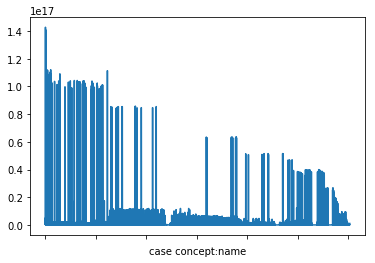

In [23]:
test_df.sort_values('event time:timestamp')['error'].apply(lambda a : a**2).plot()

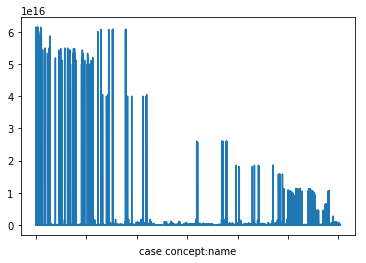

In [24]:
test_df['error'] = test_df['estimator2']-test_df['time-to-end']
test_df.sort_values('event time:timestamp')['error'].apply(lambda a : a**2).plot()

In [29]:
test_df_b.corr()

,eventID,event concept:name,time-to-end,inter-event-time,estimator,cluster,estimator2,time-since-start,error
eventID,1.000000,-0.054417,0.107493,-0.002087,-0.033917,0.021829,0.026731,0.557846,-0.096260
event concept:name,-0.054417,1.000000,-0.297130,0.491307,-0.491768,-0.017538,-0.305322,0.071316,0.049139
time-to-end,0.107493,-0.297130,1.000000,-0.325391,0.304187,-0.049661,0.544659,0.066065,-0.618050
inter-event-time,-0.002087,0.491307,-0.325391,1.000000,-0.905657,-0.130917,-0.405588,0.282766,-0.012952
estimator,-0.033917,-0.491768,0.304187,-0.905657,1.000000,0.095128,0.400595,-0.317465,0.032203
cluster,0.021829,-0.017538,-0.049661,-0.130917,0.095128,1.000000,0.139688,-0.060999,0.186987
estimator2,0.026731,-0.305322,0.544659,-0.405588,0.400595,0.139688,1.000000,-0.093174,0.322675
time-since-start,0.557846,0.071316,0.066065,0.282766,-0.317465,-0.060999,-0.093174,1.000000,-0.161901
error,-0.096260,0.049139,-0.618050,-0.012952,0.032203,0.186987,0.322675,-0.161901,1.000000


In [5]:
def get_train_data(data_set):
    df = pd.read_csv(data_set + '-training.csv', encoding="ISO-8859-1")
    df['event time:timestamp'] = df['event time:timestamp'].apply(to_date)
    return df


def get_test_data(data_set):
    df = pd.read_csv(data_set + '-test.csv', encoding="ISO-8859-1")
    df['event time:timestamp'] = df['event time:timestamp'].apply(to_date)
    return df

def to_date(x):
    # Date in format 'day-month-year hour:min:sec.milsec':
    day, month, year = str(x).split(" ")[0].split("-")
    hour, minute, sec = str(x).split(" ")[1].split(":")
    second, milsec = sec.split(".")
    return datetime.datetime(int(year), int(month), int(day), int(hour), int(minute), int(second), int(milsec) * 1000)



def remove_incomplete(data):
    #data.sort_values(by=['case concept:name', 'event time:timestamp'])
    #tails = data.groupby('case concept:name').tail(1)
    #heads = data.groupby('case concept:name').head(1)
    #begin_event = heads['event concept:name'].unique()[
    #    heads.groupby('event concept:name')['event concept:name'].transform('count').unique() >= 0.25 * len(heads)]
    #end_event = tails['event concept:name'].unique()[
    #    tails.groupby('event concept:name')['event concept:name'].transform('count').unique() >= 0.25 * len(tails)]
    #heads = heads[heads['event concept:name'].isin(begin_event)]
    #tails = tails[tails['event concept:name'].isin(end_event)]
    #data = data[data['case concept:name'].isin(heads['case concept:name']) & data['case concept:name'].isin(
    #    tails['case concept:name'])]
    return data

In [6]:
name = 'BPI_Challenge_2019'
nblocks = 100
df_train = remove_incomplete(get_train_data(name))
df_test = get_test_data(name)

In [8]:
df_train.groupby('case concept:name').tail(1)

,eventID,case Spend area text,case Company,case Document Type,case Sub spend area text,case Purchasing Document,case Purch. Doc. Category name,case Vendor,case Item Type,case Item Category,...,case Name,case GR-Based Inv. Verif.,case Item,case concept:name,case Goods Receipt,event User,event org:resource,event concept:name,event Cumulative net worth (EUR),event time:timestamp
744,3285649981442,NaN,companyID_0000,Standard PO,NaN,4507000358,Purchase order,vendorID_0171,Standard,"3-way match, invoice before GR",...,vendor_0169,False,20,4507000358_00020,True,user_075,user_075,Change Quantity,8.0,2018-01-02 12:25:00
757,3345779523584,Additives,companyID_0000,Standard PO,Plasticizers,4507000363,Purchase order,vendorID_0174,Standard,"3-way match, invoice before GR",...,vendor_0172,False,10,4507000363_00010,True,user_075,user_075,Create Purchase Order Item,10053.0,2018-01-02 12:35:00
759,3350074490880,Additives,companyID_0000,Standard PO,Plasticizers,4507000364,Purchase order,vendorID_0174,Standard,"3-way match, invoice before GR",...,vendor_0172,False,10,4507000364_00010,True,user_075,user_075,Create Purchase Order Item,10053.0,2018-01-02 12:36:00
837,3667902070785,Packaging,companyID_0000,Standard PO,Labels,4507000392,Purchase order,vendorID_0188,Consignment,Consignment,...,vendor_0185,False,10,4507000392_00010,True,user_085,user_085,Delete Purchase Order Item,0.0,2018-01-02 14:04:00
1019,2551210573826,Packaging,companyID_0000,Standard PO,Plastic Containers & Lids < 30L,4507000280,Purchase order,vendorID_0104,Standard,"3-way match, invoice before GR",...,vendor_0104,False,10,4507000280_00010,True,user_060,user_060,Delete Purchase Order Item,397.0,2018-01-02 18:02:00
1236,4453881086067,Logistics,companyID_0000,Standard PO,Road Packed,4507000473,Purchase order,vendorID_0234,Service,"3-way match, invoice after GR",...,vendor_0229,True,1,4507000473_00001,True,batch_02,batch_02,Record Goods Receipt,11838.0,2018-01-02 23:40:00
1244,4458176053251,Logistics,companyID_0000,Standard PO,Sea,4507000474,Purchase order,vendorID_0235,Service,"3-way match, invoice after GR",...,vendor_0230,True,1,4507000474_00001,True,batch_02,batch_02,Record Goods Receipt,270.0,2018-01-02 23:45:00
1894,6347961663489,Sales,companyID_0000,Standard PO,Products for Resale,4507000627,Purchase order,vendorID_0196,Standard,"3-way match, invoice before GR",...,vendor_0193,False,40,4507000627_00040,True,user_089,user_089,Delete Purchase Order Item,2156.0,2018-01-03 12:02:00
1895,6343666696193,Sales,companyID_0000,Standard PO,Products for Resale,4507000627,Purchase order,vendorID_0196,Standard,"3-way match, invoice before GR",...,vendor_0193,False,30,4507000627_00030,True,user_089,user_089,Delete Purchase Order Item,1363.0,2018-01-03 12:02:00
1896,6335076761601,Sales,companyID_0000,Standard PO,Products for Resale,4507000627,Purchase order,vendorID_0196,Standard,"3-way match, invoice before GR",...,vendor_0193,False,10,4507000627_00010,True,user_089,user_089,Delete Purchase Order Item,410.0,2018-01-03 12:02:00
